In [4]:
# Анализ Активности Пользователей Стримингового Сервиса

# Этот файл содержит Python-код для анализа данных, визуализации и проверки гипотез.
# Включает SQL-запросы, анализ pandas, когортные таблицы, визуализации (matplotlib, seaborn, plotly) и расчёты ARPU/LTV.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta

In [6]:
# 1. Загрузка данных 
users_df = pd.read_csv("users.csv", parse_dates=["registration_date"])
subscriptions_df = pd.read_csv("subscriptions.csv", parse_dates=["subscription_date"])
events_df = pd.read_csv("events.csv", parse_dates=["event_date"])

print(f"Пользователи: {len(users_df)}")
print(f"Подписки: {len(subscriptions_df)}")
print(f"События: {len(events_df)}")

Пользователи: 5000
Подписки: 1978
События: 85843


In [7]:
# 2. Когортный Анализ
# Объединяем пользователей и события для получения даты регистрации каждого события
events_with_reg = pd.merge(events_df, users_df[["user_id", "registration_date"]], on="user_id", how="left")

In [8]:
events_with_reg.head(5)

,user_id,event_date,event_type,session_duration,registration_date
0,1,2023-10-06,video_start,53,2023-04-25
1,1,2023-07-09,video_start,87,2023-04-25
2,1,2023-12-20,video_pause,50,2023-04-25
3,1,2024-05-29,ad_view,104,2023-04-25
4,2,2024-04-04,video_complete,110,2023-08-17


In [9]:
# Определяем когорту по месяцу регистрации
events_with_reg["cohort_month"] = events_with_reg["registration_date"].dt.to_period("M")
events_with_reg["event_month"] = events_with_reg["event_date"].dt.to_period("M")
events_with_reg.head(5)

,user_id,event_date,event_type,session_duration,registration_date,cohort_month,event_month
0,1,2023-10-06,video_start,53,2023-04-25,2023-04,2023-10
1,1,2023-07-09,video_start,87,2023-04-25,2023-04,2023-07
2,1,2023-12-20,video_pause,50,2023-04-25,2023-04,2023-12
3,1,2024-05-29,ad_view,104,2023-04-25,2023-04,2024-05
4,2,2024-04-04,video_complete,110,2023-08-17,2023-08,2024-04


In [10]:
# Рассчитываем когортный период (месяцы с момента регистрации)
events_with_reg["cohort_period"] = (events_with_reg["event_month"] - events_with_reg["cohort_month"]).apply(lambda x: x.n)
events_with_reg.head(5)

,user_id,event_date,event_type,session_duration,registration_date,cohort_month,event_month,cohort_period
0,1,2023-10-06,video_start,53,2023-04-25,2023-04,2023-10,6
1,1,2023-07-09,video_start,87,2023-04-25,2023-04,2023-07,3
2,1,2023-12-20,video_pause,50,2023-04-25,2023-04,2023-12,8
3,1,2024-05-29,ad_view,104,2023-04-25,2023-04,2024-05,13
4,2,2024-04-04,video_complete,110,2023-08-17,2023-08,2024-04,8


In [11]:
# Подсчитываем активных пользователей на когорту и период
cohort_counts = (
    events_with_reg
    .groupby(["cohort_month", "cohort_period"])["user_id"]
    .nunique()
    .reset_index()
)

cohort_counts.head(5)

,cohort_month,cohort_period,user_id
0,2023-01,0,67
1,2023-01,1,128
2,2023-01,2,138
3,2023-01,3,122
4,2023-01,4,143


In [12]:
# Сводная таблица для показателей удержания
cohort_pivot = (
    cohort_counts
    .pivot_table(
        index="cohort_month"
        , columns="cohort_period"
        , values="user_id"
    )
)

cohort_pivot.head(5)

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
cohort_month,,,,,,,,,,,,,,,,,,,
2023-01,67.0,128.0,138.0,122.0,143.0,135.0,130.0,141.0,113.0,125.0,131.0,128.0,139.0,110.0,131.0,142.0,134.0,125.0,117.0
2023-02,72.0,118.0,141.0,133.0,130.0,118.0,133.0,125.0,124.0,135.0,124.0,131.0,127.0,129.0,125.0,144.0,130.0,118.0,NaN
2023-03,96.0,150.0,164.0,150.0,153.0,151.0,148.0,160.0,159.0,155.0,165.0,154.0,153.0,137.0,140.0,166.0,151.0,NaN,NaN
2023-04,98.0,170.0,168.0,178.0,172.0,166.0,169.0,146.0,166.0,178.0,169.0,170.0,161.0,164.0,154.0,131.0,NaN,NaN,NaN
2023-05,127.0,177.0,184.0,181.0,175.0,193.0,178.0,184.0,188.0,187.0,188.0,180.0,175.0,179.0,165.0,NaN,NaN,NaN,NaN


In [20]:
# Рассчитываем коэффициент удержания
cohort_sizes = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0)

print("Матрица удержания:")
print(retention_matrix.head())

Матрица удержания:
cohort_period   0         1         2         3         4         5   \
cohort_month                                                           
2023-01        1.0  1.910448  2.059701  1.820896  2.134328  2.014925   
2023-02        1.0  1.638889  1.958333  1.847222  1.805556  1.638889   
2023-03        1.0  1.562500  1.708333  1.562500  1.593750  1.572917   
2023-04        1.0  1.734694  1.714286  1.816327  1.755102  1.693878   
2023-05        1.0  1.393701  1.448819  1.425197  1.377953  1.519685   

cohort_period        6         7         8         9         10        11  \
cohort_month                                                                
2023-01        1.940299  2.104478  1.686567  1.865672  1.955224  1.910448   
2023-02        1.847222  1.736111  1.722222  1.875000  1.722222  1.819444   
2023-03        1.541667  1.666667  1.656250  1.614583  1.718750  1.604167   
2023-04        1.724490  1.489796  1.693878  1.816327  1.724490  1.734694   
2023-05       

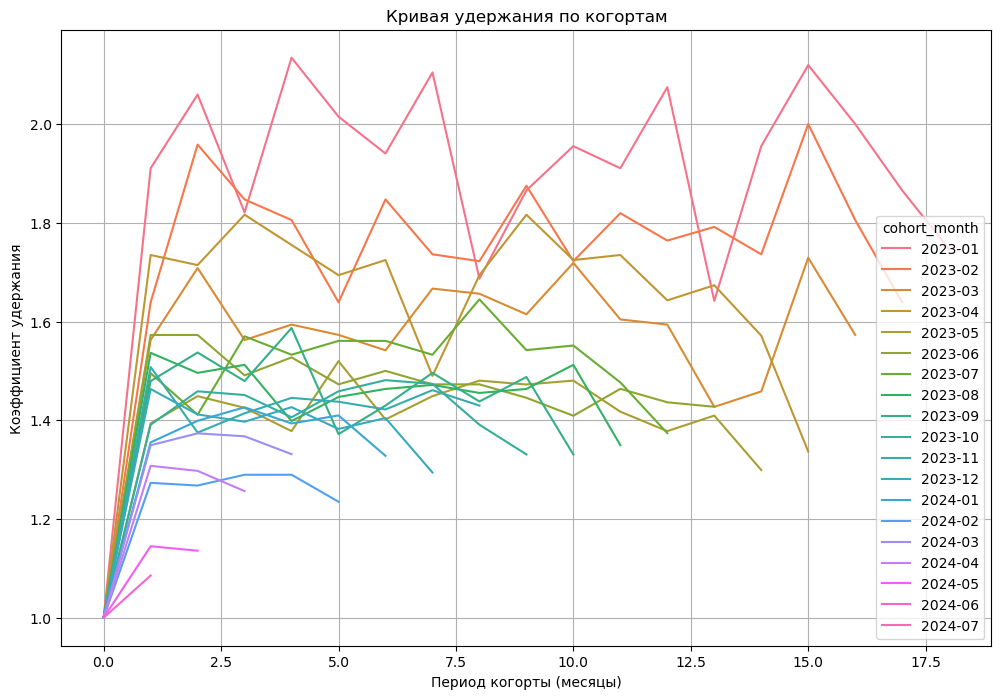

In [21]:
# Строим кривую удержания
plt.figure(figsize=(12, 8))
sns.lineplot(data=retention_matrix.T, dashes=False)

plt.title("Кривая удержания по когортам")
plt.xlabel("Период когорты (месяцы)")
plt.ylabel("Коэффициент удержания")
plt.grid(True)

plt.show()

In [15]:
# 3. Анализ LTV (Lifetime Value)
# Рассчитываем ARPU (Average Revenue Per User) для подписчиков
subscribers_revenue =(
    subscriptions_df
    .groupby("user_id")["monthly_price"]
    .sum()
    .reset_index()
)

subscribers_revenue.rename(columns={"monthly_price": "total_revenue"}, inplace=True)

subscribers_revenue.head(5)

,user_id,total_revenue
0,2,699
1,5,699
2,6,699
3,7,299
4,10,299


In [16]:
# Объединяем с пользователями для получения даты регистрации
subscribers_ltv = pd.merge(subscribers_revenue, users_df[["user_id", "registration_date"]], on="user_id", how="left")
subscribers_ltv.head(5)

,user_id,total_revenue,registration_date
0,2,699,2023-08-17
1,5,699,2024-06-01
2,6,699,2023-07-23
3,7,299,2024-04-04
4,10,299,2023-04-15


In [22]:
# Рассчитываем время жизни пользователя (упрощённо: от регистрации до конца периода данных)
end_of_data = events_df["event_date"].max()
subscribers_ltv["lifetime_days"] = (end_of_data - subscribers_ltv["registration_date"]).dt.days

# Простой расчёт LTV (общий доход / количество пользователей)
# Это упрощённый LTV. Для более точного расчёта требуются показатель оттока и средний доход на платящего пользователя с учётом времени.
ltv = subscribers_ltv["total_revenue"].sum() / len(subscribers_ltv)
print(f"Упрощенный LTV: {ltv:.2f}")

Упрощенный LTV: 500.82


In [18]:
# --- 4. A/B-Тест (Симуляция) ---
# Симулируем A/B-тест влияния скидки на конверсию в платную подписку
# Предполагаем две группы: Контрольная (без скидки) и Тестовая (со скидкой)

np.random.seed(42)
n_users_ab = 1000

# Контрольная группа: более низкая конверсия
control_conversions = np.random.binomial(1, 0.05, n_users_ab) # 5% конверсия

# Тестовая группа: повышенная конверсия благодаря скидке
test_conversions = np.random.binomial(1, 0.093, n_users_ab) # 9.3% конверсия (рост на 4.3%)

# Выполняем t-тест для независимых выборок
t_stat, p_value = stats.ttest_ind(test_conversions, control_conversions, equal_var=False)

print(f"\nРезультаты А/В теста:")
print(f"Конверсия контрольной группы: {np.mean(control_conversions):.3f}")
print(f"Конверсия тестовой группы: {np.mean(test_conversions):.3f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Вывод: Разница в коэффициентах конверсии статистически значима (p-value < 0.05).")
    print("Скидки, вероятно, увеличивают конверсию.")
else:
    print("Вывод: Разница в коэффициентах конверсии не статистически значима (p-value >= 0.05).")


Результаты А/В теста:
Конверсия контрольной группы: 0.046
Конверсия тестовой группы: 0.094
T-statistic: 4.2233
P-value: 0.0000
Вывод: Разница в коэффициентах конверсии статистически значима (p-value < 0.05).
Скидки, вероятно, увеличивают конверсию.


Ключевые выводы:
- Когортный анализ показывает динамику удержания пользователей во времени.
- Упрощённый LTV даёт первоначальную оценку ценности пользователя.
- Смоделированный A/B-тест показывает, что скидки могут значительно увеличить конверсию.

Рекомендации:
- Дальнейшее исследование факторов, влияющих на удержание, особенно для ранних когорт.
- Внедрить целевые кампании скидок на основе сегментов пользователей, выявленных в ходе анализа.
- Разработать более сложную модель LTV, учитывающую отток и доход на платящего пользователя с течением времени.
- Исследовать поведенческие паттерны пользователей на разных типах устройств (мобильные vs десктопные).